# Performance evaluation for CNN using different activation functions 

The given code represents the comparison of three differenc activation functions used for convolution layers in CNN for P300 Speller: sigmoid, tanh and ReLU. 
The obtained results show that the ReLU is more efficient, as it does not suffer from the vanishing gradient problem and achieves better accuracy. Thus, ReLU can be used for the further experiments

In [1]:
!pip install mat4py

You should consider upgrading via the '/Users/apple/.pyenv/versions/3.7.3/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
from mat4py import loadmat 
from keras.utils import to_categorical
from tensorflow import keras
import time
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [3]:
!ls

BCI_Horizon2020_dataset          SeperateSubjectsSVM.ipynb
CNN                              combinedDataset
Gradient descent.ipynb           dataset
LinearDiscriminantAnalysis.ipynb dataset.zip
MST kNN 200FoldValidation.ipynb  kNN.ipynb
MultiChannelEEGPreprocessing.m   kaggle_P300
README.md                        keras-2conv-network-75-acc.ipynb
SVM.ipynb                        makeCombinedDataset.ipynb
SVMComparison.ipynb              makeDatatsetBCI.ipynb
SVMbySubjects.ipynb


In [2]:
np.random.seed(816)
device = tf.test.gpu_device_name()

In [3]:
device

''

In [4]:
folder = 'kaggle_P300/*.mat'
files = glob.glob(folder)
#files.pop(0) #drop the data badly structured
test_file = files.pop(0) #last subject for testing the network

In [5]:
print(files)

['kaggle_P300/P300S03.mat', 'kaggle_P300/P300S01.mat', 'kaggle_P300/P300S04.mat', 'kaggle_P300/P300S05.mat', 'kaggle_P300/P300S07.mat', 'kaggle_P300/P300S06.mat', 'kaggle_P300/P300S08.mat']


In [6]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

In [7]:
def prepare_data(file):
  allX = []
  allY = []
  allT = []
  allF = []
  raw_data = loadmat(file)
  useful_data = raw_data['data'].copy()
  X = useful_data['X']
  Y = useful_data['y']
  T = useful_data['trial']
  F = useful_data['flash']
  # X_mean = np.mean(X, axis=1)
  X_filtered = butter_lowpass_filter(X, cutoff, fs, order)
  
  return X_filtered, Y, T, F

In [8]:
def normalized(vec):
  norm_vec = (vec - vec.min(axis=1, keepdims=True))/vec.ptp(axis=1, keepdims=True)
  return norm_vec

In [9]:
def clean_data(X, Y, flash):
  
  X_samples = np.array([np.array(X[i[0]:i[0]+351]) for i in flash] )
  column    = [i[2] for i in flash]
  label     = [i[3] - 1 for i in flash]
  
  LIMIT = 4080 #the last trial is incomplete
  X_selected = np.array(X_samples[:LIMIT])
  col_selected = np.array(column[:LIMIT])
  label_selected = np.array(label[:LIMIT])

  y = np.array(to_categorical(label_selected))

  false_idx = [k for k, i in enumerate(y) if i[0] == 1]
  true_idx  = [k for k, i in enumerate(y) if i[0] == 0]

  falseX = X_selected[false_idx]
  falsey = y[false_idx]

  trueX  = X_selected[true_idx]  
  truey  = y[true_idx]
  # proportional data to avoid greedy cost funtion

  proportionalX = falseX[:int(len(trueX))]
  proportionaly = falsey[:int(len(truey))]

  finalX = np.concatenate((trueX, proportionalX))
  finaly = np.concatenate((truey, proportionaly))

  X_timeseries = np.vstack(finalX)
  X_letters = X_timeseries.reshape(34,40,351,8)
  y_letters = finaly.reshape(34,40,2)
  cleaned_X = np.vstack(X_letters)
  cleaned_Y = np.vstack(y_letters)
  
  return cleaned_X, cleaned_Y

In [10]:
import tensorflow as tf

from tensorflow import keras
tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras import layers

input_layer = keras.Input(shape = (351,8,1), name='main_input')
x     = layers.Conv2D(8, 4, padding='same', activation='tanh')(input_layer)
x     = layers.Conv2D(4, 2, padding='same', activation='tanh')(x)
x     = layers.GlobalAveragePooling2D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(64)(x)
output = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 351, 8, 8)         136       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130   

In [37]:
input_layer = keras.Input(shape = (351,8,1), name='main_input')
x     = layers.Conv2D(8, 4, padding='same', activation='sigmoid')(input_layer)
x     = layers.Conv2D(4, 2, padding='same', activation='sigmoid')(x)
x     = layers.GlobalAveragePooling2D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(64)(x)
output = layers.Dense(2, activation='softmax')(x)

modelSigmoid = keras.Model(inputs=input_layer, outputs=output)

modelSigmoid.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 351, 8, 8)         136       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130 

In [44]:
input_layer = keras.Input(shape = (351,8,1), name='main_input')
x     = layers.Conv2D(8, 4, padding='same', activation='relu')(input_layer)
x     = layers.Conv2D(4, 2, padding='same', activation='relu')(x)
x     = layers.GlobalAveragePooling2D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(64)(x)
output = layers.Dense(2, activation='softmax')(x)

modelRelu= keras.Model(inputs=input_layer, outputs=output)

In [11]:
#compiling the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)  # default params
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [38]:
#compiling the sigmoid model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)  # default params
modelSigmoid.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
#compiling the ReLu model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)  # default params
modelRelu.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
def train_net(model):
  appX = []
  appy = []
  init = time.time()
  for file in files:
    X, Y, Trials, Flash = prepare_data(file)
    X_clean, y_clean = clean_data(X, Y, Flash)
    appX.append(X_clean)
    appy.append(y_clean)

  X = [subject for subject in appX]
  y = [subject for subject in appy]
  X_train, X_valid, y_train, y_valid = train_test_split(np.vstack(X), np.vstack(y), test_size=0.1, random_state=816)
  history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=30, epochs=75, verbose=1)
  end = time.time()
  print("time elapsed training is:", (end - init)/60, " minutes")  
  return history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']

In [40]:
accSigmoid, val_accSigmoid, lossSigmoid, val_lossSigmoid = train_net(modelSigmoid)

Epoch 1/75
286/286 [==============================] - 7s 25ms/step - loss: 0.6946 - accuracy: 0.4930 - val_loss: 0.6943 - val_accuracy: 0.5042
Epoch 2/75
286/286 [==============================] - 7s 23ms/step - loss: 0.6940 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.4958
Epoch 3/75
286/286 [==============================] - 7s 23ms/step - loss: 0.6938 - accuracy: 0.5005 - val_loss: 0.6946 - val_accuracy: 0.4958
Epoch 4/75
286/286 [==============================] - 7s 23ms/step - loss: 0.6936 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 5/75
286/286 [==============================] - 7s 23ms/step - loss: 0.6938 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 6/75
286/286 [==============================] - 7s 23ms/step - loss: 0.6934 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 7/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6934 - accuracy: 0.4986 - val_loss: 0.6934 - val_accuracy: 0.4958

Epoch 58/75
286/286 [==============================] - 6s 22ms/step - loss: 0.6803 - accuracy: 0.5679 - val_loss: 0.6803 - val_accuracy: 0.5662
Epoch 59/75
286/286 [==============================] - 6s 22ms/step - loss: 0.6802 - accuracy: 0.5664 - val_loss: 0.6802 - val_accuracy: 0.5683
Epoch 60/75
286/286 [==============================] - 6s 23ms/step - loss: 0.6804 - accuracy: 0.5629 - val_loss: 0.6849 - val_accuracy: 0.5620
Epoch 61/75
286/286 [==============================] - 6s 23ms/step - loss: 0.6798 - accuracy: 0.5692 - val_loss: 0.6803 - val_accuracy: 0.5725
Epoch 62/75
286/286 [==============================] - 6s 22ms/step - loss: 0.6802 - accuracy: 0.5680 - val_loss: 0.6812 - val_accuracy: 0.5945
Epoch 63/75
286/286 [==============================] - 6s 22ms/step - loss: 0.6800 - accuracy: 0.5677 - val_loss: 0.6805 - val_accuracy: 0.5704
Epoch 64/75
286/286 [==============================] - 6s 22ms/step - loss: 0.6797 - accuracy: 0.5715 - val_loss: 0.6804 - val_accuracy:

In [50]:
accRelu, val_accRelu, lossRelu, val_lossRelu = train_net(modelRelu)

Epoch 1/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6890 - accuracy: 0.5244 - val_loss: 0.6885 - val_accuracy: 0.5326
Epoch 2/75
286/286 [==============================] - 6s 23ms/step - loss: 0.6809 - accuracy: 0.5633 - val_loss: 0.6852 - val_accuracy: 0.5683
Epoch 3/75
286/286 [==============================] - 6s 23ms/step - loss: 0.6794 - accuracy: 0.5698 - val_loss: 0.6887 - val_accuracy: 0.5567
Epoch 4/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6794 - accuracy: 0.5733 - val_loss: 0.6852 - val_accuracy: 0.5693
Epoch 5/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6799 - accuracy: 0.5714 - val_loss: 0.6838 - val_accuracy: 0.5746
Epoch 6/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6806 - accuracy: 0.5684 - val_loss: 0.6844 - val_accuracy: 0.5630
Epoch 7/75
286/286 [==============================] - 7s 23ms/step - loss: 0.6797 - accuracy: 0.5678 - val_loss: 0.6846 - val_accuracy: 0.5746

Epoch 58/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6777 - accuracy: 0.5782 - val_loss: 0.6820 - val_accuracy: 0.5767
Epoch 59/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6778 - accuracy: 0.5735 - val_loss: 0.6824 - val_accuracy: 0.5987
Epoch 60/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6776 - accuracy: 0.5715 - val_loss: 0.6823 - val_accuracy: 0.5809
Epoch 61/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6777 - accuracy: 0.5752 - val_loss: 0.6827 - val_accuracy: 0.5767
Epoch 62/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6777 - accuracy: 0.5773 - val_loss: 0.6816 - val_accuracy: 0.5767
Epoch 63/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6777 - accuracy: 0.5778 - val_loss: 0.6831 - val_accuracy: 0.5914
Epoch 64/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6772 - accuracy: 0.5798 - val_loss: 0.6826 - val_accuracy:

In [13]:
#tanh 
acc, val_acc, loss, val_loss = train_net(model)

Epoch 1/75
286/286 [==============================] - 7s 26ms/step - loss: 0.6936 - accuracy: 0.4968 - val_loss: 0.6936 - val_accuracy: 0.5042
Epoch 2/75
286/286 [==============================] - 7s 25ms/step - loss: 0.6933 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.5042
Epoch 3/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6933 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 4/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6933 - accuracy: 0.4964 - val_loss: 0.6934 - val_accuracy: 0.4979
Epoch 5/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6935 - accuracy: 0.4926 - val_loss: 0.6932 - val_accuracy: 0.4863
Epoch 6/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4685
Epoch 7/75
286/286 [==============================] - 7s 24ms/step - loss: 0.6933 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.4958

Epoch 58/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6800 - accuracy: 0.5706 - val_loss: 0.6829 - val_accuracy: 0.5651
Epoch 59/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6801 - accuracy: 0.5693 - val_loss: 0.6816 - val_accuracy: 0.5630
Epoch 60/75
286/286 [==============================] - 6s 20ms/step - loss: 0.6796 - accuracy: 0.5715 - val_loss: 0.6814 - val_accuracy: 0.5746
Epoch 61/75
286/286 [==============================] - 6s 21ms/step - loss: 0.6799 - accuracy: 0.5701 - val_loss: 0.6809 - val_accuracy: 0.5788
Epoch 62/75
286/286 [==============================] - 6s 21ms/step - loss: 0.6793 - accuracy: 0.5711 - val_loss: 0.6820 - val_accuracy: 0.5746
Epoch 63/75
286/286 [==============================] - 6s 21ms/step - loss: 0.6805 - accuracy: 0.5642 - val_loss: 0.6817 - val_accuracy: 0.5651
Epoch 64/75
286/286 [==============================] - 6s 21ms/step - loss: 0.6794 - accuracy: 0.5706 - val_loss: 0.6828 - val_accuracy:

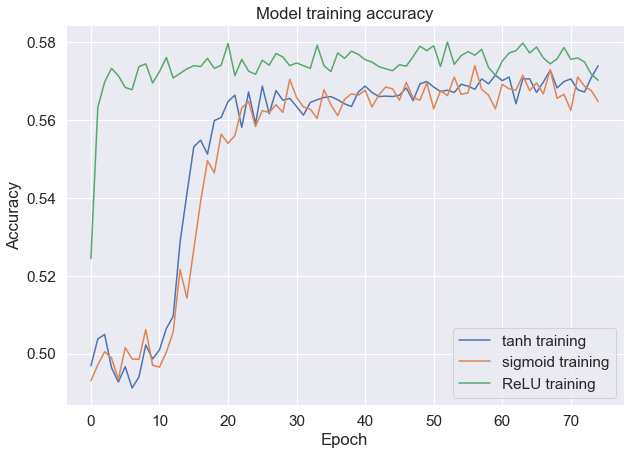

In [66]:
# Plot train and val accuracy values
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(acc)
#plt.plot(val_acc)
plt.plot(accSigmoid)
plt.plot(accRelu)
#plt.plot(val_accSigmoid)
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['tanh training',  'sigmoid training', 'ReLU training' ], loc='lower right')
plt.show()


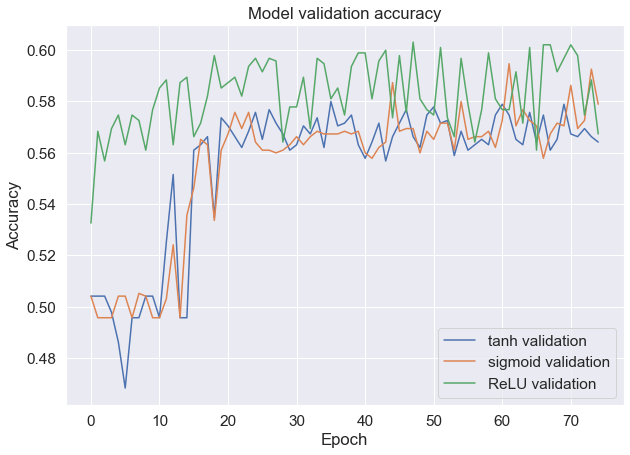

In [63]:
plt.rcParams["figure.figsize"] = (10,7)
#plt.plot(acc)
plt.plot(val_acc)
#plt.plot(accSigmoid)
plt.plot(val_accSigmoid)
plt.plot(val_accRelu)
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['tanh validation',  'sigmoid validation', 'ReLU validation' ], loc='lower right')
plt.show()

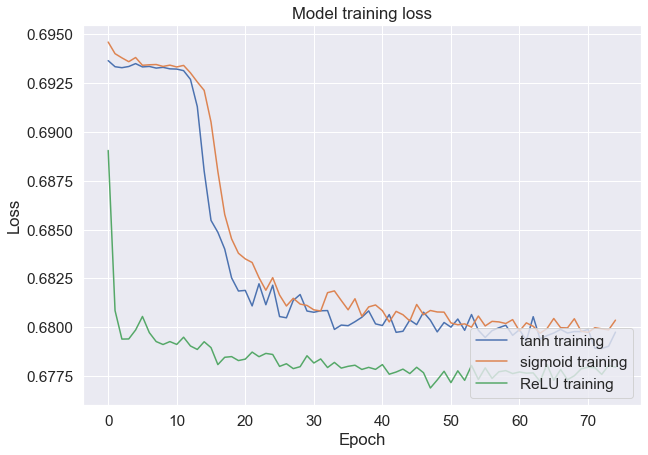

In [61]:
# Plot train and validation accuracy values
plt.plot(loss)
plt.plot(lossSigmoid)
plt.plot(lossRelu)
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tanh training','sigmoid training', 'ReLU training'], loc='lower right')
plt.show()


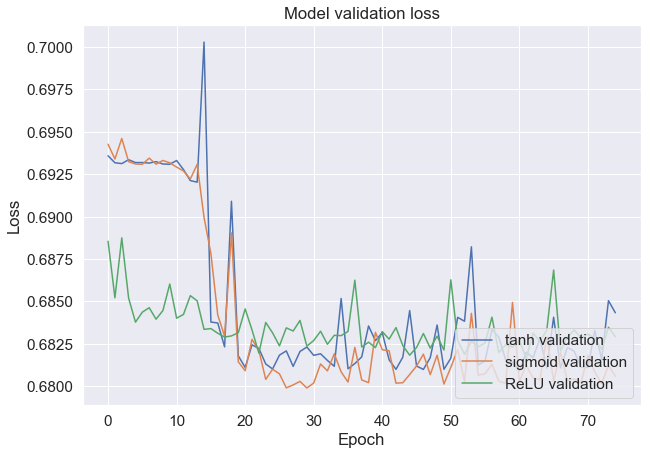

In [60]:
plt.plot(val_loss)
plt.plot(val_lossSigmoid)
plt.plot(val_lossRelu)
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tanh validation','sigmoid validation', 'ReLU validation'], loc='lower right')
plt.show()

In [16]:
X, Y, Trials, Flash = prepare_data(test_file)
X_clean, y_clean = clean_data(X, Y, Flash)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.1, random_state=816)
history = model.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6741 - accuracy: 0.5891
Epoch 2/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6521 - accuracy: 0.6119
Epoch 3/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6344 - accuracy: 0.6405
Epoch 4/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6268 - accuracy: 0.6560
Epoch 5/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6216 - accuracy: 0.6585
Epoch 6/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6107 - accuracy: 0.6814
Epoch 7/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6120 - accuracy: 0.6724
Epoch 8/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.5946 - accuracy: 0.6732
Epoch 9/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6001 - accuracy: 0.6969
Epoch 10/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.586

In [67]:
historySigmoid = modelSigmoid.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.7039 - accuracy: 0.4804
Epoch 2/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6841 - accuracy: 0.5441
Epoch 3/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6738 - accuracy: 0.5842
Epoch 4/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6703 - accuracy: 0.5850
Epoch 5/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6690 - accuracy: 0.6029
Epoch 6/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6662 - accuracy: 0.6021
Epoch 7/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6694 - accuracy: 0.5948
Epoch 8/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6699 - accuracy: 0.5972
Epoch 9/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.6676 - accuracy: 0.5940
Epoch 10/20
1224/1224 [==============================] - 3s 3ms/step - loss: 0.667

In [70]:
historyRelu = modelRelu.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6751 - accuracy: 0.5931
Epoch 2/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6363 - accuracy: 0.6446
Epoch 3/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.6166 - accuracy: 0.6716
Epoch 4/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.5847 - accuracy: 0.7026
Epoch 5/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.5818 - accuracy: 0.7181
Epoch 6/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.5743 - accuracy: 0.7255
Epoch 7/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.5567 - accuracy: 0.7345
Epoch 8/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.5573 - accuracy: 0.7353
Epoch 9/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.5459 - accuracy: 0.7516
Epoch 10/20
1224/1224 [==============================] - 4s 3ms/step - loss: 0.539

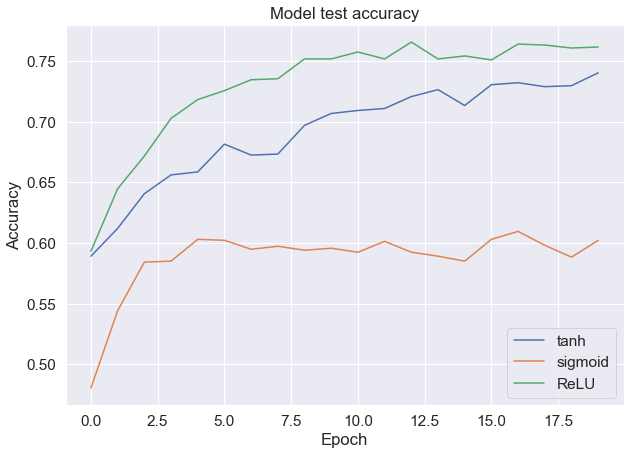

In [71]:
# Plot test accuracy values
plt.plot(history.history['accuracy'])
plt.plot(historySigmoid.history['accuracy'])
plt.plot(historyRelu.history['accuracy'])
plt.title('Model test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['tanh', 'sigmoid', 'ReLU'], loc='lower right')
plt.show()


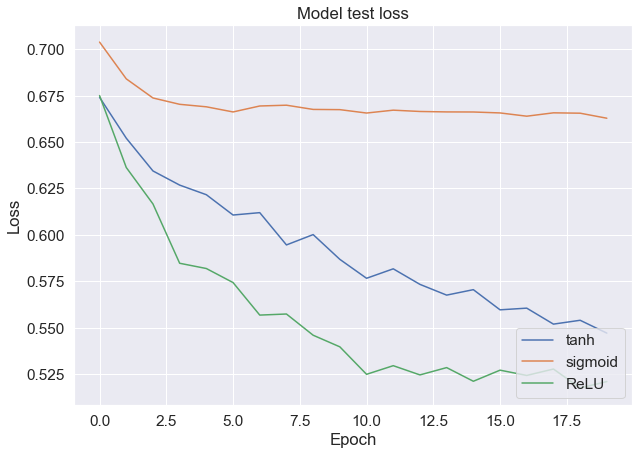

In [73]:
# Plot test loss values
plt.plot(history.history['loss'])
plt.plot(historySigmoid.history['loss'])
plt.plot(historyRelu.history['loss'])
plt.title('Model test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tanh', 'sigmoid', 'ReLU'], loc='lower right')
plt.show()

In [19]:
score = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.6181 - accuracy: 0.6544


In [75]:
score = modelSigmoid.evaluate(X_test, y_test)

5/5 [==============================] - 0s 6ms/step - loss: 0.7142 - accuracy: 0.5956


In [76]:
score = modelRelu.evaluate(X_test, y_test)

5/5 [==============================] - 0s 6ms/step - loss: 0.5284 - accuracy: 0.7426


In [20]:
init = time.time()
preds = model.predict(X_test)
end = time.time()
print("time elapsed for each trial in tanh is:",(end - init)/X_test.shape[0] * 1000, "ms")

time elapsed for each trial is: 2.698125208125395 ms


In [77]:
init = time.time()
preds = modelSigmoid.predict(X_test)
end = time.time()
print("time elapsed for each trial in sigmoid is:",(end - init)/X_test.shape[0] * 1000, "ms")

time elapsed for each trial in sigmoid is: 0.8076376774731805 ms


In [78]:
init = time.time()
preds = modelRelu.predict(X_test)
end = time.time()
print("time elapsed for each trial in ReLU is:",(end - init)/X_test.shape[0] * 1000, "ms")

time elapsed for each trial in ReLU is: 0.750823932535508 ms


In [74]:
model.save('CNNwith2ConvLayerTanh.h5') 
modelSigmoid.save('CNNwith2ConvLayerSigmoid.h5') 
modelRelu.save('CNNwith2ConvLayerRelu.h5') 